In [1]:
!pip install psycopg2-binary sqlalchemy pandas

In [15]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt  
import seaborn as sns

In [8]:
#  PostgreSQL connection settings

username = "postgres"     
password = "password"   
host = "localhost"
port = "5432"
database = "amazon_db"


In [9]:
#  Create SQLAlchemy engine
engine = create_engine(f'postgresql+psycopg2://{'postgres'}:{'password'}@{'localhost'}:{'5432'}/{'amazon_db'}')


# 1. Top Selling Products

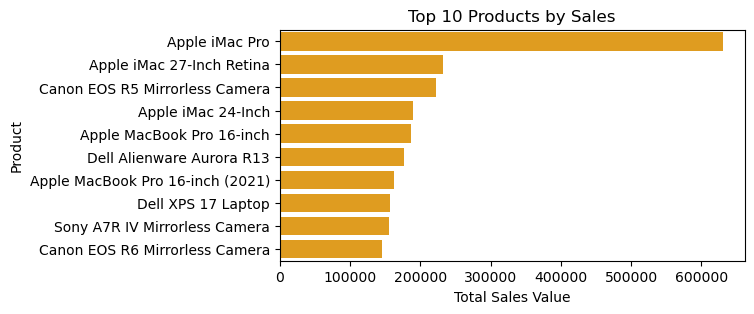

In [26]:
query = """SELECT 
	oi.product_id,
	p.product_name,
	SUM(oi.total_sale) as total_sale,
	COUNT(o.order_id)  as total_orders
FROM orders as o
JOIN
order_items as oi
ON oi.order_id = o.order_id
JOIN 
products as p
ON p.product_id = oi.product_id
GROUP BY 1, 2
ORDER BY 3 DESC
LIMIT 10"""

df_products = pd.read_sql(query, con= engine)

plt.figure(figsize=(6,3))
sns.barplot(
    x="total_sale",
    y="product_name",
    data=df_products,
    color="orange"
)
plt.title("Top 10 Products by Sales")
plt.xlabel("Total Sales Value")
plt.ylabel("Product")
plt.show()


# 2. Revenue by Category

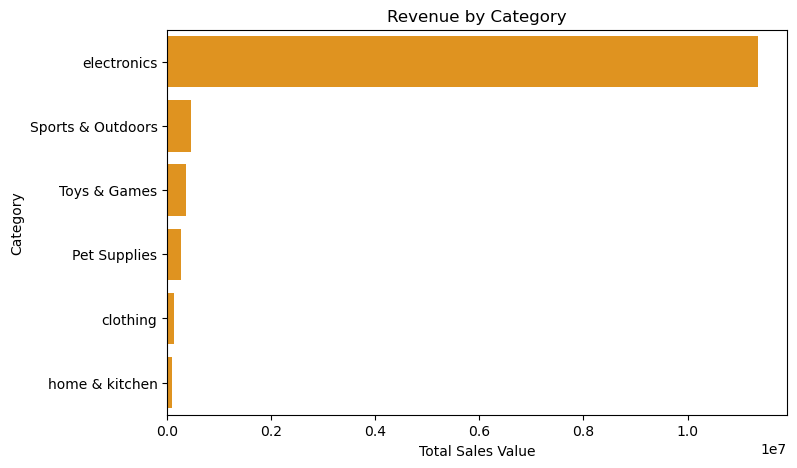

In [37]:
query = """
SELECT 
    c.category_name,
    SUM(oi.total_sale) AS total_sale
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN category c ON p.category_id = c.category_id
GROUP BY c.category_name
ORDER BY total_sale DESC;
"""

# Load data
df_category = pd.read_sql(query, con=engine)

# Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x="total_sale", y="category_name", data=df_category, color="#FF9900")  # Amazon orange
plt.title("Revenue by Category")
plt.xlabel("Total Sales Value")
plt.ylabel("Category")
plt.show()

# 3. Average Order Value (AOV)

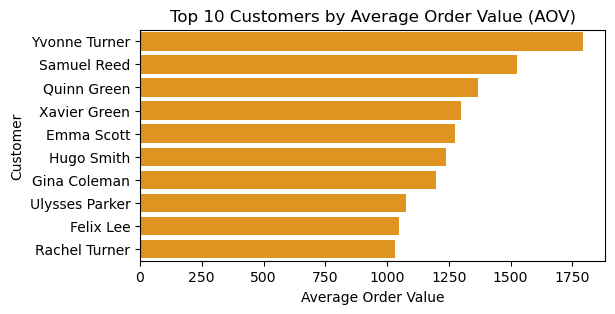

In [42]:
query = """
SELECT 
    c.customer_id,
    CONCAT(c.first_name, ' ', c.last_name) AS full_name,
    SUM(total_sale)/COUNT(o.order_id) AS AOV,
    COUNT(o.order_id) AS total_orders
FROM orders o
JOIN customers c ON c.customer_id = o.customer_id
JOIN order_items oi ON oi.order_id = o.order_id
GROUP BY c.customer_id, full_name
HAVING COUNT(o.order_id) > 5
ORDER BY AOV DESC
LIMIT 10;
"""

df_aov = pd.read_sql(query, con=engine)


plt.figure(figsize=(6,3))
sns.barplot(x="aov", y="full_name", data=df_aov, color="#FF9900")  
plt.title("Top 10 Customers by Average Order Value (AOV)")
plt.xlabel("Average Order Value")
plt.ylabel("Customer")
plt.show()


# 4. Customers with No Purchases

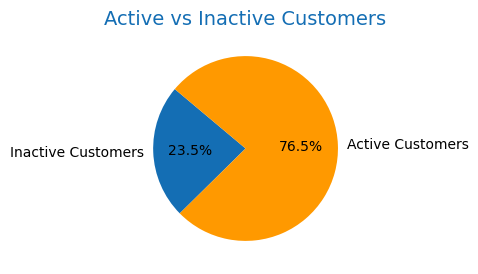

In [50]:
query = """
SELECT 
    CASE 
        WHEN c.customer_id IN (SELECT DISTINCT customer_id FROM orders) 
        THEN 'Active Customers'
        ELSE 'Inactive Customers'
    END AS customer_status,
    COUNT(*) AS total_customers
FROM customers c
GROUP BY customer_status;
"""

df_status = pd.read_sql(query, con=engine)

# Pie chart
plt.figure(figsize=(3,3))
plt.pie(
    df_status['total_customers'],
    labels=df_status['customer_status'],
    autopct='%1.1f%%',
    startangle=140,
    colors=["#146EB4", "#FF9900"]  # Amazon colors
)
plt.title("Active vs Inactive Customers", fontsize=14, color="#146EB4")
plt.show()


# 5. Shipping Delays

C:\Users\HP\AppData\Local\Temp\ipykernel_20356\2165804900.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




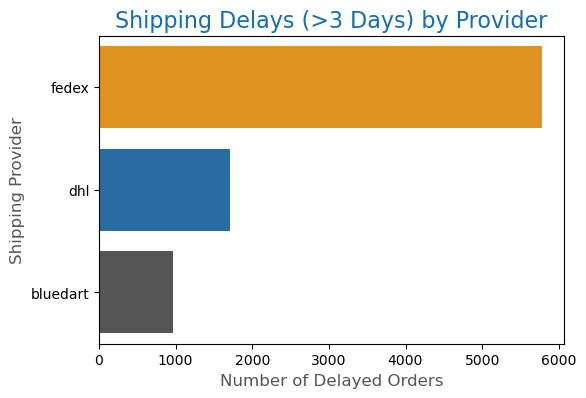

In [59]:
query = """
SELECT 
    s.shipping_providers,
    COUNT(*) AS delayed_orders,
    ROUND(AVG(s.shipping_date - o.order_date),2) AS avg_delay_days
FROM orders o
JOIN shipping s ON o.order_id = s.order_id
WHERE s.shipping_date - o.order_date > 3
GROUP BY s.shipping_providers
ORDER BY delayed_orders DESC;
"""

df_shipping = pd.read_sql(query, con=engine)


plt.figure(figsize=(6,4))
sns.barplot(
    x="delayed_orders",
    y="shipping_providers",
    data=df_shipping,
    palette=["#FF9900", "#146EB4", "#555555"] 
)
plt.title("Shipping Delays (>3 Days) by Provider", fontsize=16, color="#146EB4")
plt.xlabel("Number of Delayed Orders", fontsize=12, color="#555555")
plt.ylabel("Shipping Provider", fontsize=12, color="#555555")
plt.show()


# 6. Payment Success Rate 

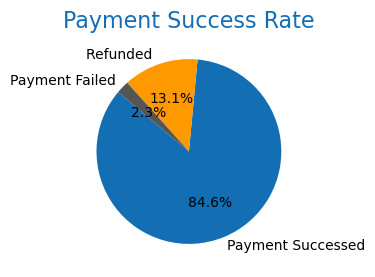

In [63]:
query = """
SELECT 
    p.payment_status,
    COUNT(*) AS total_count,
    ROUND(COUNT(*)::numeric / (SELECT COUNT(*) FROM payments) * 100, 2) AS percentage
FROM payments p
GROUP BY p.payment_status
ORDER BY total_count DESC;
"""

df_payments = pd.read_sql(query, con=engine)

# Pie Chart
plt.figure(figsize=(3,3))
plt.pie(
    df_payments['total_count'],
    labels=df_payments['payment_status'],
    autopct='%1.1f%%',
    startangle=140,
    colors=["#146EB4", "#FF9900", "#555555"]  # Amazon theme
)
plt.title("Payment Success Rate", fontsize=16, color="#146EB4")
plt.show()


# 7. Top Performing Sellers

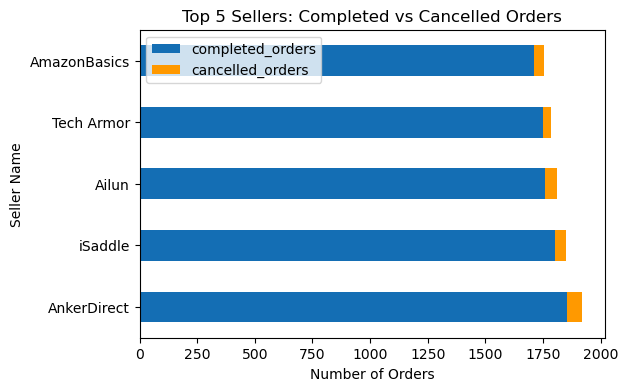

In [68]:
query = """
WITH top_sellers AS (
    SELECT 
        s.seller_id,
        s.seller_name,
        SUM(oi.total_sale) AS total_sale
    FROM orders o
    JOIN sellers s ON o.seller_id = s.seller_id
    JOIN order_items oi ON oi.order_id = o.order_id
    GROUP BY s.seller_id, s.seller_name
    ORDER BY total_sale DESC
    LIMIT 5
),
sellers_reports AS (
    SELECT 
        o.seller_id,
        ts.seller_name,
        o.order_status,
        COUNT(*) AS total_orders
    FROM orders o
    JOIN top_sellers ts ON ts.seller_id = o.seller_id
    WHERE o.order_status NOT IN ('Inprogress', 'Returned')
    GROUP BY o.seller_id, ts.seller_name, o.order_status
)
SELECT 
    seller_id,
    seller_name,
    SUM(CASE WHEN order_status = 'Completed' THEN total_orders ELSE 0 END) AS completed_orders,
    SUM(CASE WHEN order_status = 'Cancelled' THEN total_orders ELSE 0 END) AS cancelled_orders,
    SUM(total_orders) AS total_orders,
    ROUND(SUM(CASE WHEN order_status = 'Completed' THEN total_orders ELSE 0 END)::numeric 
          / SUM(total_orders)::numeric * 100, 2) AS success_percentage
FROM sellers_reports
GROUP BY seller_id, seller_name
ORDER BY total_orders DESC;
"""

# Read SQL data into DataFrame
df_sellers = pd.read_sql(query, con=engine)

df_sellers.plot(
    kind='barh',
    x='seller_name',
    y=['completed_orders', 'cancelled_orders'],
    stacked=True,
    figsize=(6,4),
    color=['#146EB4', '#FF9900']  
)
plt.title("Top 5 Sellers: Completed vs Cancelled Orders")
plt.xlabel("Number of Orders")
plt.ylabel("Seller Name")
plt.show()


# 8. Most Returned Products

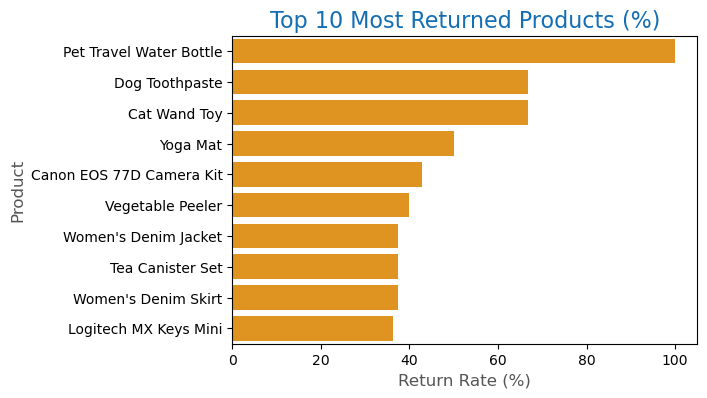

In [79]:
query = """SELECT 
    p.product_id,
    p.product_name,
    COUNT(*) AS total_units_sold,
    SUM(CASE WHEN o.order_status = 'Returned' THEN 1 ELSE 0 END) AS total_returned,
    ROUND(SUM(CASE WHEN o.order_status = 'Returned' THEN 1 ELSE 0 END)::numeric / COUNT(*)::numeric * 100, 2) AS return_percentage
FROM order_items oi
JOIN products p ON oi.product_id = p.product_id
JOIN orders o ON o.order_id = oi.order_id
GROUP BY p.product_id, p.product_name
ORDER BY return_percentage DESC
LIMIT 10;
"""
df_returned = pd.read_sql(query, con=engine)

plt.figure(figsize=(6,4))
sns.barplot(
    x="return_percentage",
    y="product_name",
    data=df_returned,
    color="#FF9900"
)
plt.title("Top 10 Most Returned Products (%)", fontsize=16, color="#146EB4")
plt.xlabel("Return Rate (%)", fontsize=12, color="#555555")
plt.ylabel("Product", fontsize=12, color="#555555")
plt.show()

# 9. Top 5 Customers by Orders

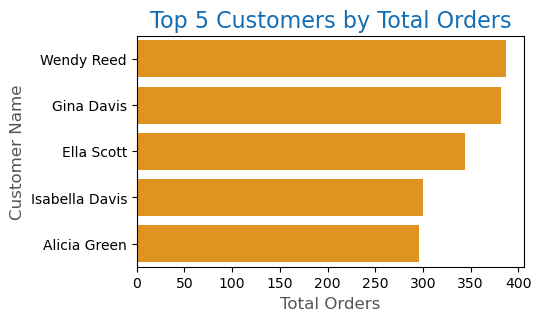

In [83]:

query = """SELECT 
    CONCAT(c.first_name, ' ', c.last_name) AS customer_name,
    COUNT(o.order_id) AS total_orders,
    SUM(oi.total_sale) AS total_sale
FROM orders o
JOIN order_items oi ON oi.order_id = o.order_id
JOIN customers c ON c.customer_id = o.customer_id
GROUP BY customer_name
ORDER BY total_orders DESC
LIMIT 5;
"""
df_top_customers = pd.read_sql(query, con=engine)

# Plot horizontal bar chart
plt.figure(figsize=(5,3))
sns.barplot(
    x="total_orders",
    y="customer_name",
    data=df_top_customers,
    color="#FF9900"  # Amazon orange
)
plt.title("Top 5 Customers by Total Orders", fontsize=16, color="#146EB4")
plt.xlabel("Total Orders", fontsize=12, color="#555555")
plt.ylabel("Customer Name", fontsize=12, color="#555555")
plt.show()


# 10.  Revenue by Shipping Provider

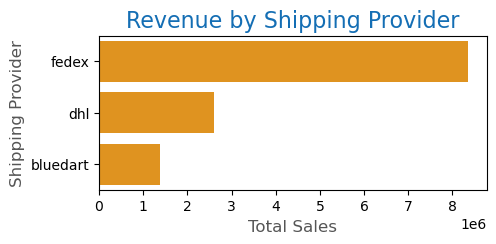

In [88]:

query = """SELECT 
    s.shipping_providers,
    COUNT(o.order_id) AS order_handled,
    SUM(oi.total_sale) AS total_sale,
    COALESCE(AVG(s.return_date - s.shipping_date), 0) AS average_delivery_days
FROM orders o
JOIN order_items oi ON oi.order_id = o.order_id
JOIN shipping s ON s.order_id = o.order_id
GROUP BY s.shipping_providers
ORDER BY total_sale DESC;
"""
df_shipping = pd.read_sql(query, con=engine)

# Horizontal bar chart: Total Sales by Shipping Provider
plt.figure(figsize=(5,2))
sns.barplot(
    x="total_sale",
    y="shipping_providers",
    data=df_shipping,
    color="#FF9900"  # Amazon orange
)
plt.title("Revenue by Shipping Provider", fontsize=16, color="#146EB4")
plt.xlabel("Total Sales", fontsize=12, color="#555555")
plt.ylabel("Shipping Provider", fontsize=12, color="#555555")
plt.show()


# 11. Monthly Sales trend(2023 & 2024)

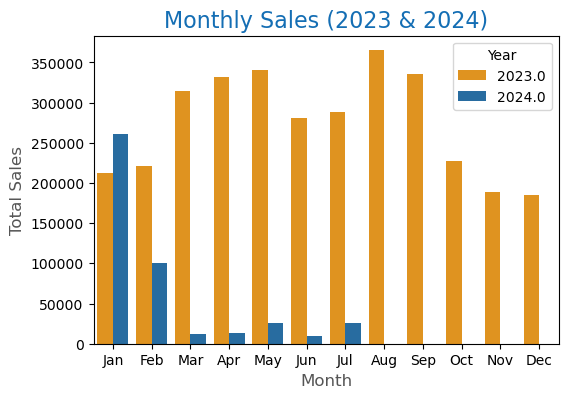

In [95]:

query = """SELECT 
    EXTRACT(YEAR FROM o.order_date) AS year,
    EXTRACT(MONTH FROM o.order_date) AS month,
    ROUND(SUM(oi.total_sale::numeric), 2) AS total_sale
FROM orders o
JOIN order_items oi ON oi.order_id = o.order_id
WHERE EXTRACT(YEAR FROM o.order_date) IN (2023, 2024)
GROUP BY 1, 2
ORDER BY 1, 2;"""

df_monthly = pd.read_sql(query, con=engine)


df_monthly['month_name'] = df_monthly['month'].apply(
   lambda x: ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][int(x)-1]
)

# Plot monthly sales
plt.figure(figsize=(6,4))
sns.barplot(
    x='month_name',
    y='total_sale',
    hue='year',
    data=df_monthly,
    palette=["#FF9900", "#146EB4"]  
)
plt.title("Monthly Sales (2023 & 2024)", fontsize=16, color="#146EB4")
plt.xlabel("Month", fontsize=12, color="#555555")
plt.ylabel("Total Sales", fontsize=12, color="#555555")
plt.legend(title='Year')
plt.show()
